# 1. 이해하기

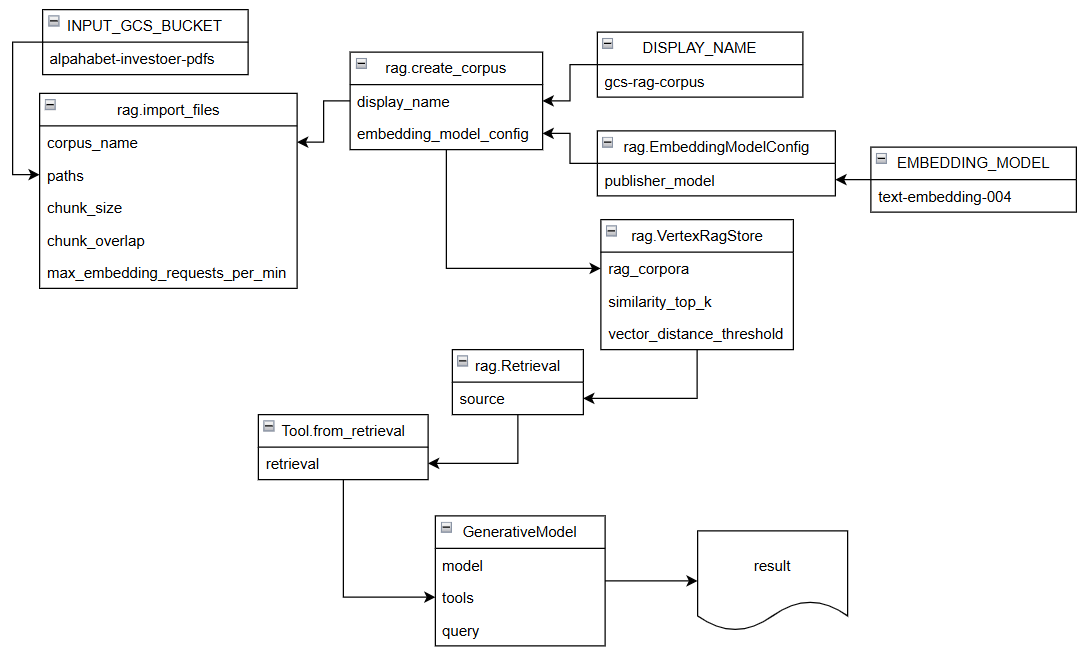

# 2. 환경설정

## 2.1 라이브러리 설치

In [ ]:
!pip install google-cloud-aiplatform

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 2.2 환경변수 설정

In [ ]:
import os

PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))
LOCATION = str(os.environ.get("GOOGLE_CLOUD_REGION", "us-central1"))

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"LOCATION: {LOCATION}")

PROJECT_ID: younkicho-364103
LOCATION: us-central1


##2.3 Gemini 초기화

In [ ]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# 3. RAG 구현

## 3.1 RAG Corpus 생성

In [ ]:
from vertexai.preview import rag

EMBEDDING_MODEL = "publishers/google/models/text-embedding-004"
DISPLAY_NAME="gcs-rag-corpus"

In [ ]:
embedding_model_config = rag.EmbeddingModelConfig(publisher_model=EMBEDDING_MODEL)

rag_corpus = rag.create_corpus(
    display_name=DISPLAY_NAME,
    embedding_model_config=embedding_model_config,
)

In [ ]:
rag.list_corpora()

ListRagCorporaPager<rag_corpora {
  name: "projects/younkicho-364103/locations/us-central1/ragCorpora/576460752303423488"
  display_name: "gcs-rag-corpus"
  rag_embedding_model_config {
    vertex_prediction_endpoint {
      endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
    }
  }
  rag_vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    }
  }
  create_time {
    seconds: 1737447434
    nanos: 933479000
  }
  update_time {
    seconds: 1737447434
    nanos: 933479000
  }
  corpus_status {
    state: ACTIVE
  }
  vector_db_config {
    rag_managed_db {
    }
    rag_embedding_model_config {
      vertex_prediction_endpoint {
        endpoint: "projects/younkicho-364103/locations/us-central1/publishers/google/models/text-embedding-004"
      }
    }

## 3.2 upload

### 3.2.1 import files from GCS

In [ ]:
INPUT_GCS_BUCKET="gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/"

response = rag.import_files(
    corpus_name=rag_corpus.name,
    paths=[INPUT_GCS_BUCKET],
    chunk_size=1024,
    chunk_overlap=100,
    max_embedding_requests_per_min=900
)

### 3.2.2 결과 확인

In [ ]:
response = rag.retrieval_query(
    rag_resources=[
        rag.RagResource(
            rag_corpus=rag_corpus.name,
            # Optional: supply IDs from `rag.list_files()`.
            # rag_file_ids=["rag-file-1", "rag-file-2", ...],
        )
    ],
    text="CEO는 누구인가?",
    similarity_top_k=10,  # Optional
    vector_distance_threshold=0.46,  # Optional
)
print(response)

contexts {
  contexts {
    source_uri: "gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/2011_google_annual_report.pdf"
    source_display_name: "2011_google_annual_report.pdf"
    text: "SECTION 1350,\r\nAS ADOPTED PURSUANT TO\r\nSECTION 906 OF THE SARBANES-OXLEY ACT OF 2002\r\nI, Larry Page, certify pursuant to 18 U.S.C. Section 1350, as adopted pursuant to Section 906 of the\r\nSarbanes-Oxley Act of 2002, that the Annual Report on Form 10-K of Google Inc. for the fiscal year ended\r\nDecember 31, 2011, fully complies with the requirements of Section 13(a) or 15(d) of the Securities Exchange Act of\r\n1934 and that information contained in such Annual Report on Form 10-K fairly presents, in all material respects,\r\nthe financial condition and results of operations of Google Inc.\r\nDate: January 26, 2012\r\nBy: /S/ LARRY PAGE\r\nName: Larry Page\r\nTitle: Chief Executive Officer\r\n(Principal Executive Officer)\r\nI, Patrick Pichette, certify pursuant to 18 U.S

# 4. 모델

## 4.1 모델 만들기

In [ ]:
from vertexai.preview.generative_models import (
    GenerativeModel,
    Tool
)
source = rag.VertexRagStore(
    rag_corpora=[rag_corpus.name],
    similarity_top_k=10,
    vector_distance_threshold=0.5
)

retrieval = rag.Retrieval(source=source)
rag_retrieval_tool = Tool.from_retrieval(retrieval)

In [ ]:
rag_gemini_model = GenerativeModel(
    "gemini-1.5-flash",
    tools=[rag_retrieval_tool]
)

In [ ]:
query="""
초대 CEO는 누구?
수집한 pdf 파일 url 출력
"""

response = rag_gemini_model.generate_content(query)

response.text

'2015년 구글 연례 보고서에 따르면, 초대 CEO는 Larry Page입니다.  해당 파일은 다음 링크에서 확인할 수 있습니다: gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/2015_google_annual_report.pdf \n'

## 4.2 RAG 삭제

In [ ]:
corpus_list=rag.list_corpora()

for corpus in corpus_list:
  rag.delete_corpus(name=corpus.name)

Successfully deleted the RagCorpus.


# 5. reference

* https://rudaks.tistory.com/entry/langchain-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EB%B6%84%ED%95%A0-Text-Splitter#google_vignette
* https://mechiru.github.io/google-api-proto/google_api_proto/google/cloud/aiplatform/v1beta1/struct.ImportRagFilesConfig.html